## Case Study - Discounts for close to expiration products (Pink Labels)
### Machine Learning - Modelo Preditivo
Carlos Silva | Maria João Fernandes | Mariana Gabriel | Marina Azevedo | Renato Flores
<a id='toc'></a>

### Indice
* [1. Importar as bibliotecas e o dataset](#importar)<br>
    * [1.1. Importar as bibliotecas](#lib)<br>
    * [1.2. Importar e integrar os dados](#data)<br>
* [2. Preparação dos Dados - Método K-Fold Cross-Validation](#prep) <br>
    * [2.1. Feature Selection ](#fea)<br>
       * [2.1.1. Variáveis Categóricas](#cat)<br>
          * [2.1.1.1 Chi-Square (Filter Method)](#chi)<br>
       * [2.1.2. Variáveis Numéricas](#num)<br>
          * [2.1.2.1 Variance (Filter Method)](#var)<br>
          * [2.1.2.2 Spearman Correlation (Filter Method)](#spear)<br>
          * [2.1.2.3 Decision Trees (Embedded Method)](#trees)<br>
          * [2.1.2.4 Recursive Feature Elimination (RFE) (Wrapper Method)](#rfe)<br>
          * [2.1.2.5 Lasso](#lasso)<br>
* [3. Modelo e Avaliação (Modelagem e Avaliação)](#model) <br>
    * [3.1. Seleção do Modelo](#sel)<br>
    * [3.2. Otimização do Modelo](#otm)<br>
       * [3.2.1. Hiperparâmetros](#hiper)<br>
          * [3.2.1.1 RandomSearch](#rand)<br>
          * [3.2.1.2  GridSearch](#grid)<br>
          * [3.2.1.3  Alterar o threshold](#threshold)<br>
* [4. Deploy](#deploy) <br>
    * [4.1. Obter as previsões nos dados de teste a partir do modelo final](#prev)<br>
    * [4.2. Criação do DataFrame com o índice de cada linha e a respectiva previsão](#dataframe)<br>




O case study analisado em seguida, bem como anteriormente na análise exploratória de dados, provêm da necessidade levantada por parte de um cliente de compreender a forma mais eficiente para minimizar perdas e aumentar a conversão de produtos próximos da data de validade (produtos com etiquetas rosas). Desta forma, o objetivo principal desta analise é desenvolver um estudo que permita maximizar o lucro obtido nas vendas dos produtos, evitando de igual forma o desperdício financeiro para a empresa, apresentando, assim, uma solução viável ao cliente para a rentabilidade do negócio.

Nesta fase final do projeto, será desenvolvido um modelo de classificação preditiva capaz de prever se um produto será vendido, considerando a taxa de desconto e as suas características, através da utilização de técnicas analíticas e da avaliação de desempenho para garantir a eficácia do modelo.

O dataset contém informações detalhadas sobre os produtos vendidos pelo cliente e foi modificado na primeira fase do projeto de forma a garantir a limpeza e clareza dos dados a serem explorados e analisados.

Desta forma, os objetivos desta analise exploratória de dados será:

- Encontrar as melhores variáveis preditivas;
- Desenvolver um modelo de classificação preditiva que seja capaz de prever se um produto será vendido, considerando a taxa de desconto e suas características;

<div class="alert alert-block" style="background-color:#AEC6CF; border: 1px solid #003366">
<a id='importar'>
<font color = '#003366'> 
    
# 1. Importar as bibliotecas e o dataset</font>
</a>
    
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='lib'></a>
    <h2 style="color: #003366; margin: 0;">1.1. Importar as bibliotecas</h2>
</div>

In [211]:
#Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

############################################ SELEÇÃO DE VARIÁVEIS ############################################
import scipy.stats as stats
from scipy.stats import chi2_contingency #metódo de filtro
from sklearn.feature_selection import RFE #método wrapper
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.tree import DecisionTreeClassifier, plot_tree #método embutido
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,roc_curve,precision_recall_curve


import warnings
warnings.filterwarnings('ignore')


<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='data'></a>
    <h2 style="color: #003366; margin: 0;">1.2. Importar e integrar os dados</h2>
</div>

In [214]:
data=pd.read_csv("Data_labels_clean.csv",sep=';', index_col=0)

In [215]:
data.head(5)

,Idstore,Sku,Brand,Oldpvp,Labelqty,Weight,Payment_Method,Margin,Profit,Perc_Expiring_Sku,Expiring_Date,Labelling_Date,Sell_Date,Sold,Type,Selling_Square_Ft,District,Newpvp,Discount
0,1,1,1,4.22,1,260.0,Card,0.16,0.3376,0.010050,2021-10-03,2021-10-01,2021-10-02,1.0,Large,4762.0,Évora,2.11,0.5
1,1,1,1,3.96,1,260.0,NaN,0.16,0.3168,0.005025,2021-10-02,2021-10-01,NaN,0.0,Large,4762.0,Évora,1.98,0.5
2,1,1,1,4.74,1,260.0,Cash,0.16,0.3792,0.010050,2021-10-03,2021-10-01,2021-10-03,1.0,Large,4762.0,Évora,2.37,0.5
3,1,1,1,4.20,1,260.0,Card,0.16,0.3360,0.010050,2021-10-03,2021-10-01,2021-10-02,1.0,Large,4762.0,Évora,2.10,0.5
4,1,1,1,4.62,1,260.0,Cash,0.16,0.3696,0.010050,2021-10-03,2021-10-01,2021-10-03,1.0,Large,4762.0,Évora,2.31,0.5


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150053 entries, 0 to 150053
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Idstore            150053 non-null  int64  
 1   Sku                150053 non-null  int64  
 2   Brand              150053 non-null  int64  
 3   Oldpvp             150053 non-null  float64
 4   Labelqty           150053 non-null  int64  
 5   Weight             150053 non-null  float64
 6   Payment_Method     80511 non-null   object 
 7   Margin             150053 non-null  float64
 8   Profit             150053 non-null  float64
 9   Perc_Expiring_Sku  150053 non-null  float64
 10  Expiring_Date      150053 non-null  object 
 11  Labelling_Date     150053 non-null  object 
 12  Sell_Date          80511 non-null   object 
 13  Sold               150053 non-null  float64
 14  Type               150053 non-null  object 
 15  Selling_Square_Ft  150053 non-null  float64
 16  Distric

**Conclusões:**
Verifica-se que o dataset está tratado, sem missing values e com o tipo correto para as variáveis. 

*Nota:* A falta de dados no Payment_Method e na Sell_Date indica que nem todos os produtos foram vendidos.

<div class="alert alert-block" style="background-color:#AEC6CF; border: 1px solid #003366">
<a id='prep'>
<font color = '#003366'> 
    
# 2. Preparação dos Dados - Método K-Fold Cross-Validation</font>
</a>
    
</div>

Para este dataset será tilizado o método K-Fold Cross-Validation para avaliação do modelo, devido a ser a mais apropriada para o tamanho do conjunto de dados analisado.

In [223]:
#Criar uma nova instância de StratifiedKFold com os principais hiperparâmetros, nomeando-a como skf: n_splits = 5 ; random_state = 99 ; shuffle = True
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

In [225]:
data.columns

Index(['Idstore', 'Sku', 'Brand', 'Oldpvp', 'Labelqty', 'Weight',
       'Payment_Method', 'Margin', 'Profit', 'Perc_Expiring_Sku',
       'Expiring_Date', 'Labelling_Date', 'Sell_Date', 'Sold', 'Type',
       'Selling_Square_Ft', 'District', 'Newpvp', 'Discount'],
      dtype='object')

In [227]:
#Definir as variáveis independentes (X) e e a variável alvo (y)
X = data.drop(['Sold','Sku','Idstore','Payment_Method'], axis = 1)
y = data['Sold'].copy()

Uma vez que a variável Payment_Method está diretamente relacionada com a variável alvo, não será considerada para evitar enviesamentos.

In [230]:
#Dividir X e Y através do método train_test_split para deixar um conjunto de teste independente fora do processo de treino.
X, X_test, y, y_test = train_test_split(X, y, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y)

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='fea'></a>
    <h2 style="color: #003366; margin: 0;">2.1. Feature Selection</h2>
</div>

**Nesta etapa, será aplicado Técnicas de Seleção de Variáveis (Feature Selection), nomeadamente:**

- Variáveis Categóricas:
    - Chi-Square (Filter Method)
- Variáveis Numéricas:
    - Variance (Filter Method)
    - Spearman Correlation (Filter Method) 
    - Recursive Feature Elimination (RFE) (Wrapper Method)
    - Lasso Regression (Embedded Method)
    - Decision Trees (Embedded Method)

Os modelos de regressão são muito sensíveis a variáveis correlacionadas, pelo que se deve remover estas variáveis antes de aplicar técnicas como Lasso Regression e Recursive Feature Elimination (caso o estimator utilizado seja um modelo de regressão).

Dessa forma, será aplicado as técnicas de seleção de variáveis na seguinte ordem:

1. **Chi-Square** - Para selecionar variáveis categóricas com base na sua relação com a variável alvo;
1. **Variance** – Para verificar se há variáveis constantes;  
2. **Spearman Correlation** – Para identificar variáveis correlacionadas;  
3. **Decision Trees** – Para manter apenas uma variável de cada grupo de variáveis correlacionadas;  
4. **RFE** – Para selecionar variáveis iterativamente, considerando subconjuntos de variáveis;  
5. **Lasso** – Para identificar e selecionar variáveis importantes no conjunto de dados.

Além disto, para aplicar a seleção de variáveis corretamente, é necessário primeiro identificar o tipo de dado de cada variável, já que diferentes técnicas são específicas para diferentes tipos de dados.

| Predictor              | Data Type       |
|------------------------|-----------------|
| Idstore                | Categorical     |
| Sku                    | Categorical     |
| Brand                  | Categorical     |
| Oldpvp                 | Continuous      |
| Labelqty               | Continuous      |
| Weight                 | Continuous      |
| Payment_Method         | Categorical     |
| Margin                 | Continuous      |
| Profit                 | Continuous      |
| Perc_Expiring_Sku      | Continuous      |
| Expiring_Date          | Date            |
| Sell_Date              | Date            |
| Sold                   | Binary (Target) |
| Type                   | Categorical     |
| Selling_Square_Ft      | Continuous      |
| District               | Categorical     |
| Newpvp                 | Continuous      |
| Discount               | Continuous      |


In [235]:
X_test

,Brand,Oldpvp,Labelqty,Weight,Margin,Profit,Perc_Expiring_Sku,Expiring_Date,Labelling_Date,Sell_Date,Type,Selling_Square_Ft,District,Newpvp,Discount
69824,12,2.65,1,202.0,0.12,0.2220,0.618090,2021-10-02,2021-10-01,2021-10-02,Small,703.000000,Viseu,1.85,0.30
32258,2,2.89,1,149.0,0.19,0.3838,0.666667,2021-10-04,2021-10-02,NaN,Small,1102.074231,Castelo Branco,2.02,0.30
30279,2,2.89,1,149.0,0.19,0.3838,0.333333,2021-10-25,2021-10-24,2021-10-25,Medium,2719.000000,Braga,2.02,0.30
140781,2,1.69,1,52.0,0.20,0.2360,0.000000,2021-10-23,2021-10-23,NaN,Small,1102.074231,Bragança,1.18,0.30
96723,2,0.59,1,207.0,0.10,0.0410,0.200000,2021-10-28,2021-10-27,2021-10-28,Small,1041.000000,Évora,0.41,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100704,2,1.49,1,172.0,0.11,0.1144,0.500000,2021-10-08,2021-10-06,2021-10-07,Small,115.000000,Lisboa,1.04,0.30
149312,25,1.99,1,156.0,0.11,0.1529,0.250000,2021-10-07,2021-10-06,NaN,Small,136.000000,Setúbal,1.39,0.30
19598,20,0.99,1,72.0,0.13,0.0637,0.250000,2021-10-07,2021-10-05,NaN,Small,686.000000,Évora,0.49,0.51
30747,2,2.89,1,149.0,0.19,0.3838,0.666667,2021-10-18,2021-10-16,2021-10-18,Medium,4307.000000,Portalegre,2.02,0.30


<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='cat'></a>
    <h3 style="color: #003366; margin: 0;">2.1.1. Variáveis Categóricas</h3>
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='chi'></a>
    <h3 style="color: #003366; margin: 0;">2.1.1.1. Chi-Square (Filter Method) </h3>
</div>

Será utilizado o método chi-square para compreender qual / quais variável/ variáveis categórica deve ser mantida

In [240]:
#Criar uma função com o nome apply_chisquare para selecionar variáveis categóricas com base na sua relação com a variável alvo
def apply_chisquare(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [242]:
#Criar uma função chamada select_best_cat_features que receba as variáveis independentes (X) e a variável alvo (y).
def select_best_cat_features(X,y):
    count = 1
    
    ############################################## APLICAR SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    
        #################################### SELECIONAR AS VARIÁVEIS COM CHI-SQUARE #######################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # verificar quais variáveis usar com chi-square
        X_train_cat = X_train[['District','Type']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
            
        count+=1

In [244]:
#Verificar a função select_best_cat_features usando como argumentos as suas variáveis independentes e a variável alvo.
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
District is IMPORTANT for Prediction
Type is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
District is IMPORTANT for Prediction
Type is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________
District is IMPORTANT for 

**Conclusões:**

| Predictor | Chi-Square | O que fazer?|
| --- | --- | --- |
| District | 5 YES | Keep |
| Type | 5 YES | Keep |


Com base nas conclusões, mantemos as duas variáveis categóricas.

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='num'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2. Variáveis Numéricas</h3>
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='var'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2.1. Variance (Filter Method) </h3>
</div>

Será utilizado o método variance para compreender se os dados numéricos e ordinais são constantes ou quase constantes

In [250]:
#Criar uma função com o nome apply_variance que recebe os dados de teste e retorna a variância de cada variável.
def apply_variance(X_train):
    print(X_train.var(numeric_only=True).apply(lambda x: f"{x:.5f}"))

In [252]:
#Criar uma função chamada select_features_variance que recebe as variáveis independentes (X) e a variável alvo (y).
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

      ######################################### SELECIONAR AS VARIÁVEIS #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # Verificar quais variáveis utilizar com a variância.
        apply_variance(X_train)
            
        count+=1

In [254]:
#Verificar a função select_features_variance usando como argumentos as suas variáveis independentes e a variável alvo.
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Brand                      32.56871
Oldpvp                      0.32103
Labelqty                    0.00000
Weight                   3376.13713
Margin                      0.00109
Profit                      0.00577
Perc_Expiring_Sku           0.04955
Selling_Square_Ft    29672477.28913
Newpvp                      0.15476
Discount                    0.00135
dtype: object
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
Brand                      32.51532
Oldpvp                      0.3241

**Conclusões:**

A variável labelqty é constante pelo que pode ser eliminada.

In [257]:
X = X.drop(['Labelqty'], axis = 1)

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='spear'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2.2. Spearman Correlation (Filter Method) </h3>
</div>

Será utilizado o método da correlação de Spearman para determinar se existem variáveis redundantes que devem ser removidas devido à sua alta correlação.

In [261]:
#Criar uma função com o nome cor_heatmap que recebe uma matriz de correlação
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [263]:
#Criar uma função com o nome apply_correlation que recebe os dados de teste como entrada
def apply_correlation(X_train):
    correlation_data = X_train.copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)
    cor_heatmap(matrix)

In [265]:
#Criar uma função com o nome redundant_features que recebe as variáveis independentes (X) e a variável alvo (y).
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECIONAR AS VARIÁVEIS #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Verificar quais variáveis utilizar com a spearman correlation
        apply_correlation(X_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


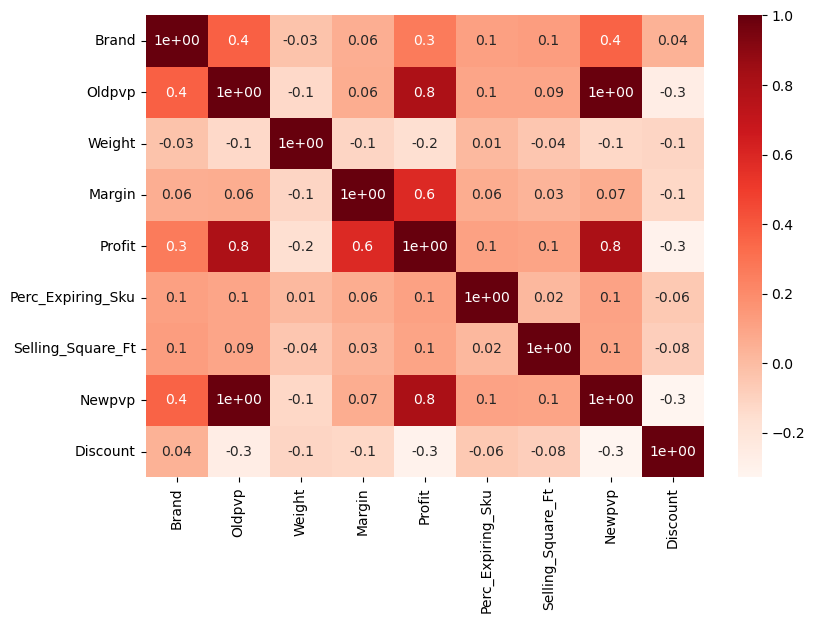

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


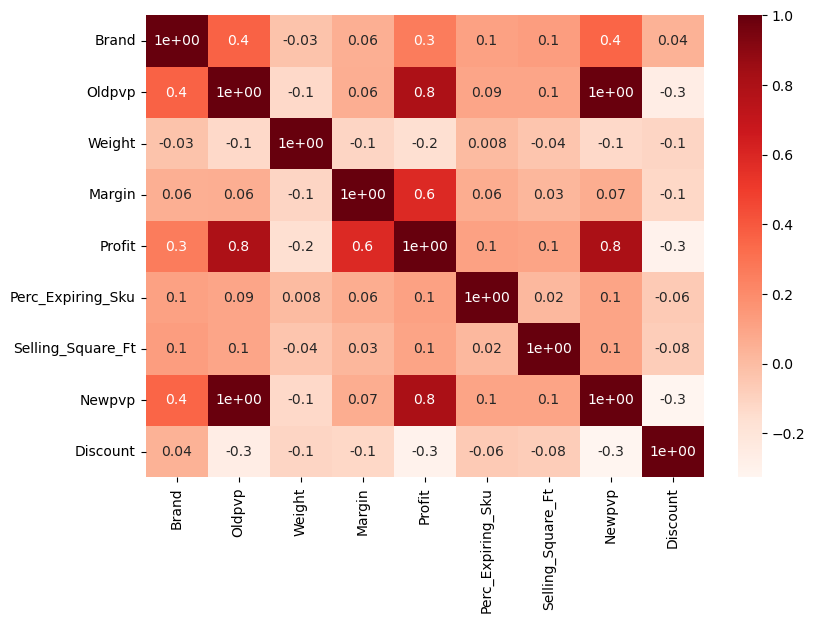

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


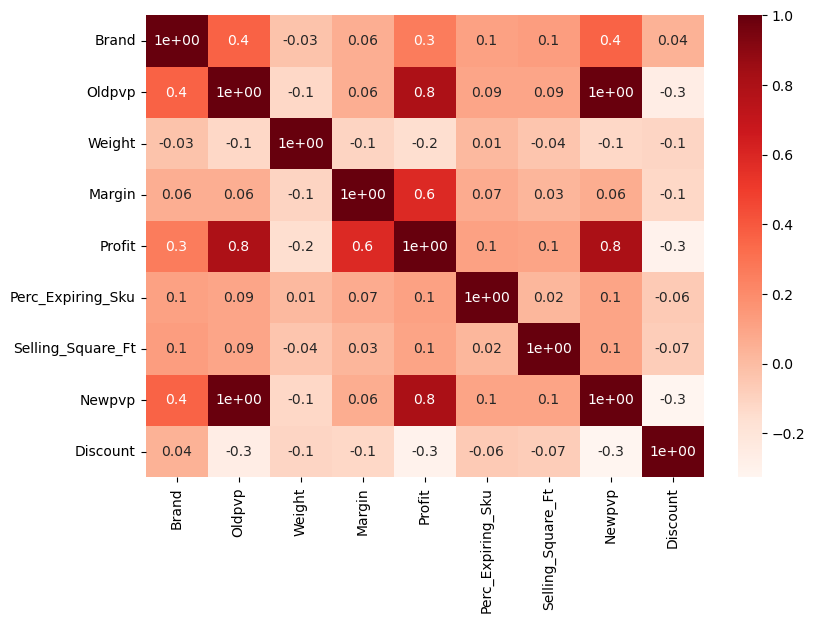

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


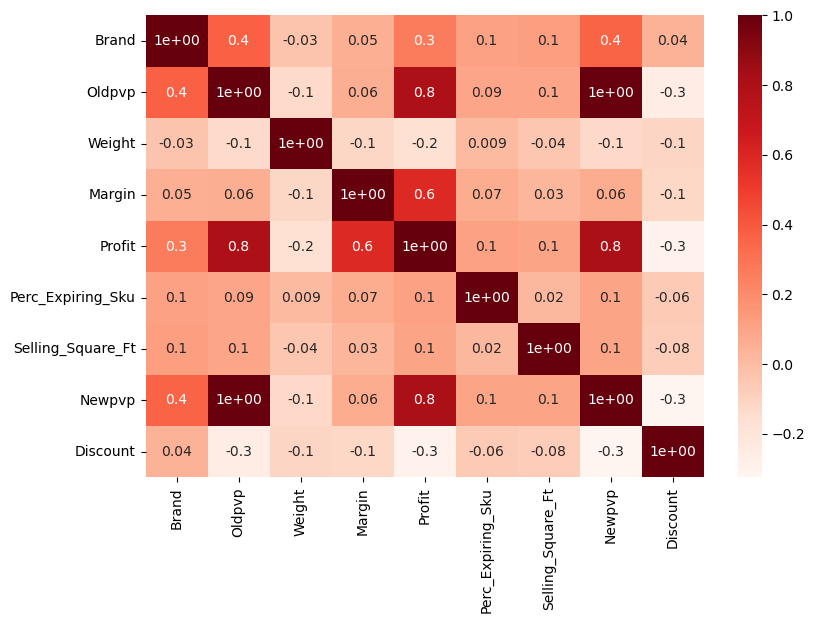

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


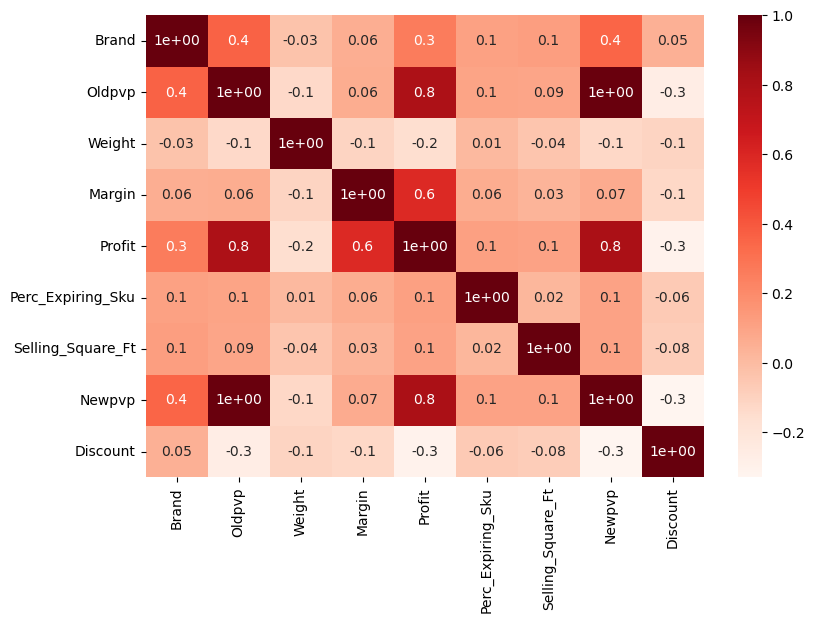

In [267]:
#Verificar a função redundant_features usando como argumentos as suas variáveis independentes e a variável alvo.
redundant_features(X, y)

**Redundant Variables - Spearman Correlation (Correlação maior que |0.8|)**

| Combinação              | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
|-------------------------|---------|---------|---------|---------|---------|
| Oldpvp vs Profit        | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     |
| Newpvp vs Profit        | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     |
| Newpvp vs Oldpvp        | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     |

Nesse caso, podemos observar que para evitar redundância deve-se eliminar duas das variáveis do grupo: Oldpvp, Newpvp e Profit.

Os próximos métodos que serão aplicados para seleção de variáveis são:

 - Wrapper methods - RFE
 - Embedded Methods - Lasso Regression and Decision Trees

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='trees'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2.3. Decision Trees (Embedded Method) </h3>
</div>

In [269]:
#Criar uma função com o nome plot_importance que recebe as features importances e o nome do modelo que está sendo aplicado
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [271]:
#Criar uma função com o nome apply_dt que recebe os dados de teste como entrada (variáveis independentes e alvo).
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

In [273]:
#Criar uma função com o nome select_best_features_dt que recebe as variáveis independentes (X) e a variável alvo (y).
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECIONAR AS VARIÁVEIS #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # Verificar quais variáveis utilizar com a decision Tree
        X_train = X_train.drop(['Expiring_Date', 'Labelling_Date', 'Sell_Date','Type','District'], axis = 1)
        apply_dt(X_train, y_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


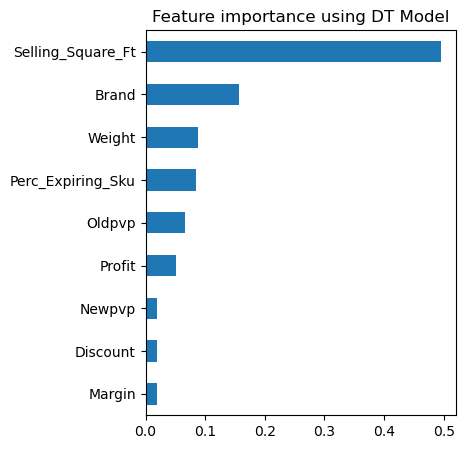

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


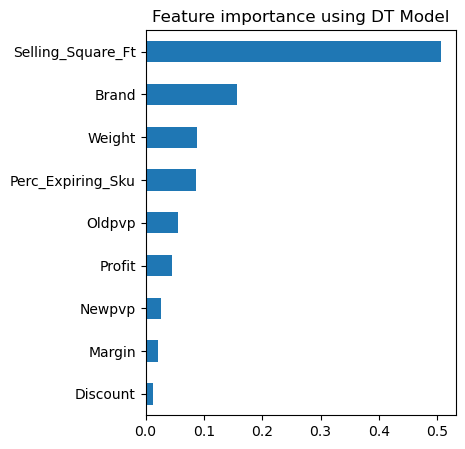

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


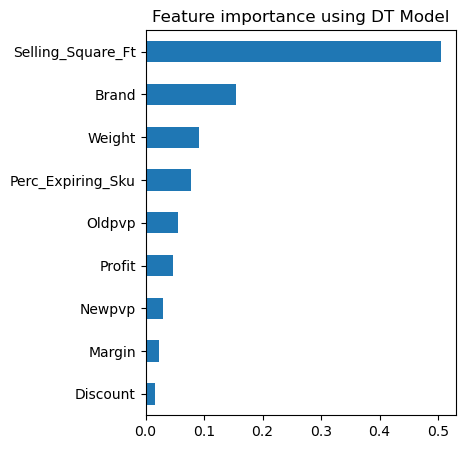

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


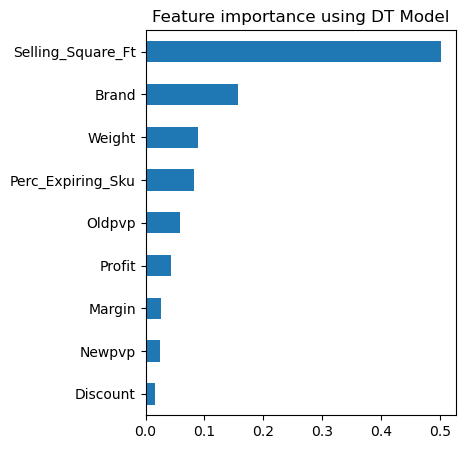

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


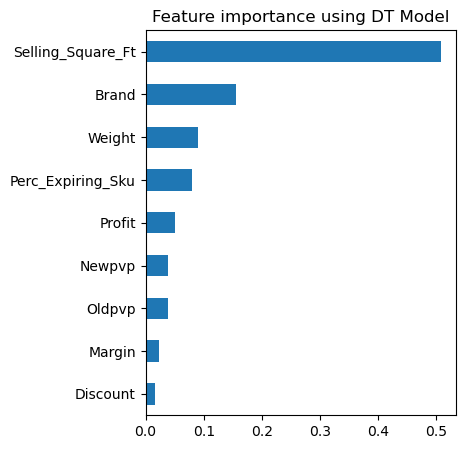

In [275]:
#Verificar a função select_best_features_dt usando como argumentos as suas variáveis independentes e a variável alvo.
select_best_features_dt(X, y)

**Importância das Variáveis por Split (Modelo de Árvore de Decisão)**

| Variável            | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
|---------------------|---------|---------|---------|---------|---------|
| Selling_Square_Ft   | Alta    | Alta    | Alta    | Alta    | Alta    |
| Brand               | Média   | Média   | Média   | Média   | Média   |
| Weight              | Baixa   | Baixa   | Baixa   | Baixa   | Baixa   |
| Perc_Expiring_Sku   | Baixa   | Baixa   | Baixa   | Baixa   | Baixa   |
| Oldpvp              | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa |
| Profit              | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa |
| Newpvp              | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa |
| Discount            | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa |
| Margin              | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa | Muito Baixa |

Com base nas conclusões, irá remover-se as variáveis Newpvp e Profit.

In [277]:
#Remover as variáveis Newpvp e Profit
X=X.drop(['Newpvp','Profit'], axis=1)

**Conclusões:**

Como já se removeu as variáveis correlacionadas, pode-se aplicar as técnicas que utilizam regressão.

*Próximos passos*
 - Aplicar a Regressão Lasso e o RFE.

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='rfe'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2.4. Recursive Feature Elimination (RFE) (Wrapper Method) </h3>
</div>

In [281]:
#Criar uma função com o nome apply_rfe que recebe os dados de teste como entrada (variáveis independentes e alvo).
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='lasso'></a>
    <h3 style="color: #003366; margin: 0;">2.1.2.5. Lasso </h3>
</div>

In [284]:
X

,Brand,Oldpvp,Weight,Margin,Perc_Expiring_Sku,Expiring_Date,Labelling_Date,Sell_Date,Type,Selling_Square_Ft,District,Discount
112744,2,2.29,167.0,0.17,0.666667,2021-10-19,2021-10-17,NaN,Small,905.0,Guarda,0.3
130220,15,1.69,265.0,0.20,0.666667,2021-10-10,2021-10-08,2021-10-09,Large,19000.0,Bragança,0.3
117509,15,1.69,167.0,0.10,0.666667,2021-10-12,2021-10-10,2021-10-12,Small,1255.0,Faro,0.3
38705,2,1.19,192.0,0.18,0.333333,2021-10-26,2021-10-25,2021-10-25,Small,413.0,Lisboa,0.3
67889,2,0.99,229.0,0.17,0.333333,2021-10-27,2021-10-26,NaN,Small,711.0,Viseu,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
140657,2,1.69,52.0,0.20,0.666667,2021-10-06,2021-10-04,NaN,Small,930.0,Beja,0.3
68026,2,0.99,229.0,0.17,0.333333,2021-10-22,2021-10-21,2021-10-21,Small,1426.0,Porto,0.3
78621,2,1.69,139.0,0.13,0.000000,2021-10-21,2021-10-21,NaN,Small,115.0,Lisboa,0.3
135660,2,1.29,165.0,0.11,0.400000,2021-10-03,2021-10-01,NaN,Small,571.0,Viana do Castelo,0.3


In [286]:
#Criar uma função com o nome apply_lasso que recebe os dados de teste como entrada (variáveis independentes e alvo).
def apply_lasso(X_train, y_train):
    #X_train = X_train.drop(['Dependents'], axis = 1)
    lasso = LogisticRegressionCV(penalty='l1', solver='saga').fit(X_train, y_train)
    coef = pd.Series(abs(lasso.coef_[0]), index = X_train.columns)
    plot_importance(coef,'Lasso')

In [288]:
#Criar uma função com o nome select_best_features que recebe as variáveis independentes (X) e a variável alvo (y).
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ########################################### SCALE DATA #################################################### 
        numerical_data = X_train.drop([ 'Expiring_Date', 'Labelling_Date', 'Sell_Date','District','Type'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        X_train_scaled = scaler.transform(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
    
        ######################################### SELECIONAR AS VARIÁVEIS #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Verificar quais variáveis utilizar com RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # Verificar quais variáveis utilizar com lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # Verificar quais variáveis utilizar com DT
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Brand                 True
Oldpvp                True
Weight               False
Margin               False
Perc_Expiring_Sku     True
Selling_Square_Ft     True
Discount              True
dtype: bool

----------------- LASSO ----------------------


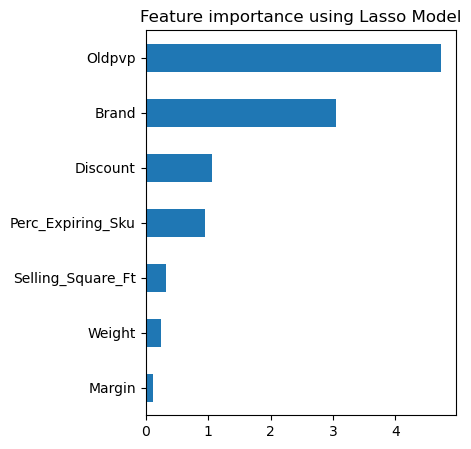


----------------- DT ----------------------


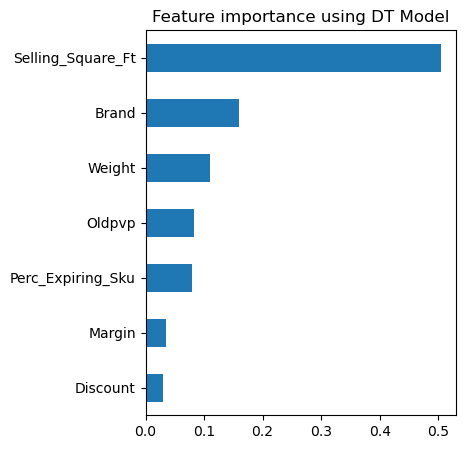

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Brand                 True
Oldpvp                True
Weight               False
Margin               False
Perc_Expiring_Sku     True
Selling_Square_Ft     True
Discount              True
dtype: bool

----------------- LASSO ----------------------


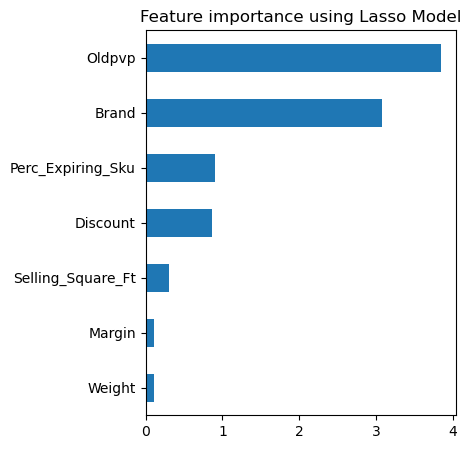


----------------- DT ----------------------


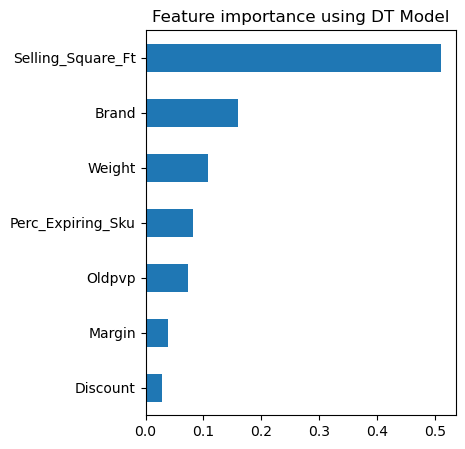

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Brand                 True
Oldpvp                True
Weight               False
Margin               False
Perc_Expiring_Sku     True
Selling_Square_Ft     True
Discount              True
dtype: bool

----------------- LASSO ----------------------


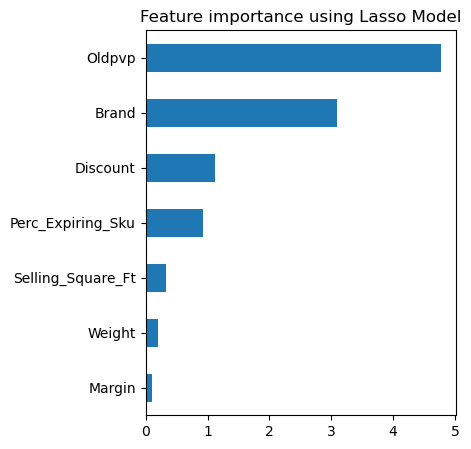


----------------- DT ----------------------


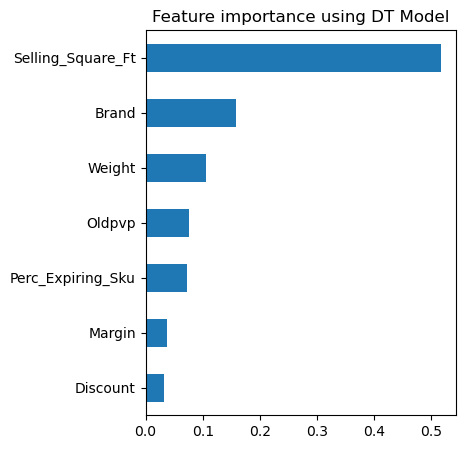

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Brand                 True
Oldpvp                True
Weight               False
Margin               False
Perc_Expiring_Sku     True
Selling_Square_Ft     True
Discount              True
dtype: bool

----------------- LASSO ----------------------


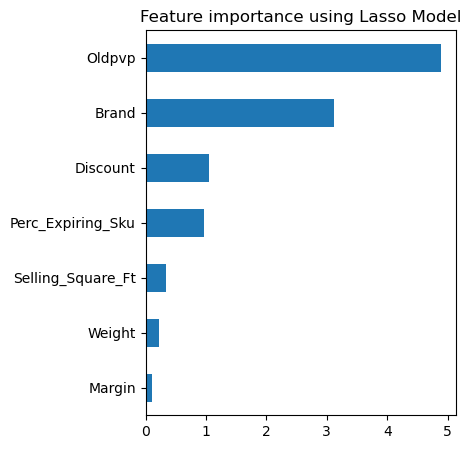


----------------- DT ----------------------


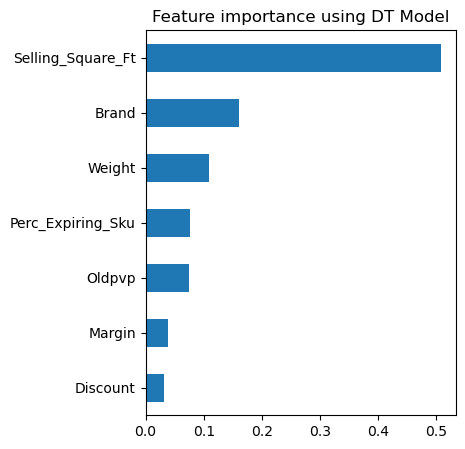

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Brand                 True
Oldpvp                True
Weight               False
Margin               False
Perc_Expiring_Sku     True
Selling_Square_Ft     True
Discount              True
dtype: bool

----------------- LASSO ----------------------


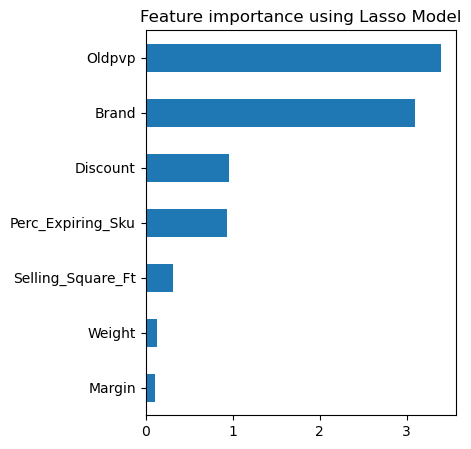


----------------- DT ----------------------


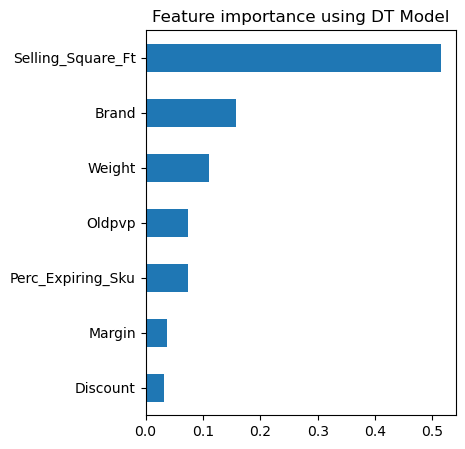

In [292]:

#Verificar a função select_best_features_dt usando como argumentos as suas variáveis independentes e a variável alvo
select_best_features(X, y)

**Conclusões:**

Com base nos três métodos utilizados (**RFE, LASSO e Decision Tree**), a melhor abordagem seria **manter**:

- **Oldpvp**
- **Selling_Square_Ft**
- **Brand**
- **Perc_Expiring_Sku**
- **Discount** (para testar)

E **remover**:

- **Margin** (pois não foi selecionado pelo RFE e tem baixa importância nos outros modelos).
- **Weight** (não foi selecionada pelo RFE e tem pouca relevância geral)


<div class="alert alert-block" style="background-color:#AEC6CF; border: 1px solid #003366">
<a id='model'>
<font color = '#003366'> 
    
# 3. Modelo e Avaliação (Modelagem e Avaliação)</font>
</a>
    
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='sel'></a>
    <h2 style="color: #003366; margin: 0;">3.1. Seleção do Modelo</h2>
</div>

In [294]:
#Importar o CSV chamado "Data_labels_clean_dummies.csv"
data_dummies=pd.read_csv("Data_labels_clean_dummies.csv",sep=';', index_col=0)

In [295]:
#Visualizar as colunas do data
data_dummies.columns

Index(['Idstore', 'Sku', 'Brand', 'Oldpvp', 'Labelqty', 'Weight',
       'Payment_Method', 'Margin', 'Profit', 'Perc_Expiring_Sku',
       'Expiring_Date', 'Labelling_Date', 'Sell_Date', 'Sold',
       'Selling_Square_Ft', 'Newpvp', 'Discount', 'District_Beja',
       'District_Braga', 'District_Bragança', 'District_Castelo Branco',
       'District_Coimbra', 'District_Faro', 'District_Guarda',
       'District_Leiria', 'District_Lisboa', 'District_Portalegre',
       'District_Porto', 'District_Santarém', 'District_Setúbal',
       'District_Viana do Castelo', 'District_Vila Real', 'District_Viseu',
       'District_Évora', 'Type_Medium', 'Type_Small'],
      dtype='object')

*Próximos passos:*

Criar dois datasets:
- Um dataset que inclui as variáveis das quais existe certeza que são importantes (keep_data);
- Outro dataset que inclui tanto as variáveis importantes quanto as que existem dúvidas (all_data).

In [299]:
#Criação dos datasets
keep_data= data_dummies[['Oldpvp','Selling_Square_Ft','Perc_Expiring_Sku','Brand','District_Beja',
       'District_Braga', 'District_Bragança', 'District_Castelo Branco',
       'District_Coimbra', 'District_Faro', 'District_Guarda',
       'District_Leiria', 'District_Lisboa', 'District_Portalegre',
       'District_Porto', 'District_Santarém', 'District_Setúbal',
       'District_Viana do Castelo', 'District_Vila Real', 'District_Viseu',
       'District_Évora', 'Type_Medium', 'Type_Small','Sold']].copy()
all_data= data_dummies[['Oldpvp','Selling_Square_Ft','Perc_Expiring_Sku','Discount','Brand', 'District_Beja',
       'District_Braga', 'District_Bragança', 'District_Castelo Branco',
       'District_Coimbra', 'District_Faro', 'District_Guarda',
       'District_Leiria', 'District_Lisboa', 'District_Portalegre',
       'District_Porto', 'District_Santarém', 'District_Setúbal',
       'District_Viana do Castelo', 'District_Vila Real', 'District_Viseu',
       'District_Évora', 'Type_Medium', 'Type_Small','Sold']].copy()

In [301]:
keep_data

,Oldpvp,Selling_Square_Ft,Perc_Expiring_Sku,Brand,District_Beja,District_Braga,District_Bragança,District_Castelo Branco,District_Coimbra,District_Faro,...,District_Porto,District_Santarém,District_Setúbal,District_Viana do Castelo,District_Vila Real,District_Viseu,District_Évora,Type_Medium,Type_Small,Sold
0,4.22,4762.0,0.010050,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
1,3.96,4762.0,0.005025,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
2,4.74,4762.0,0.010050,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
3,4.20,4762.0,0.010050,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
4,4.62,4762.0,0.010050,1,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,2.49,5048.0,0.100629,2,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,0.0
150050,2.49,9370.0,0.113208,2,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1.0
150051,2.49,9370.0,0.113208,2,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1.0
150052,3.49,1061.0,0.092437,24,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1.0


In [303]:
X_keep_data = keep_data.iloc[:,:-1]
y_keep_data = keep_data.iloc[:,-1]

In [305]:
X_all_data = all_data.iloc[:,:-1]
y_all_data = all_data.iloc[:,-1]

In [307]:
X_keep, X_test_keep, y_keep, y_test_keep = train_test_split(X_keep_data, y_keep_data, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_keep_data)

keep_data = pd.concat([X_keep, y_keep], axis=1)

In [309]:
X_all, X_test_all, y_all, y_test_all = train_test_split(X_all_data, y_all_data, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_all_data)
all_data = pd.concat([X_all, y_all], axis=1)

In [311]:
#Lista de modelos e hiperparâmetros para otimização
models_params = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]}),
    "Random Forest": (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    "AdaBoost": (AdaBoostClassifier(), {'n_estimators': [50, 100, 200]}),
    "Naive Bayes": (GaussianNB(), {})  # Sem hiperparâmetros para otimizar
}

In [313]:
#Testar os vários modelos com ajuste de hiperparâmetros utilizado o GridSearchCV
def ml_test(X, y, models_params, y_test, X_test, nome_dataset):
    # Dicionário para armazenar os resultados
    results = {}
    
    # Número máximo de gráficos a serem exibidos
    num_models = len(models_params)  
    num_plots = min(num_models, 7)  # Garantir que apenas 7 gráficos sejam desenhados
    
    # Criando uma figura para as matrizes de confusão
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Grade 3x3
    fig.suptitle("Matrizes de Confusão para Todos os Modelos", fontsize=16)
    axes = axes.ravel()  # Achatar a matriz de eixos para facilitar o acesso
    
    # Testando cada modelo com GridSearchCV para ajuste de hiperparâmetros
    for idx, (name, (model, params)) in enumerate(models_params.items()):
        if idx >= num_plots:
            break  # Para quando atingir o número desejado
        
        print(f"🔄 Treinando {name}...")
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X, y)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Calculando métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            "Best Params": grid_search.best_params_,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1}
        
        # Calculando e plotando a matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot(ax=axes[idx], cmap=plt.cm.Blues)
        axes[idx].set_title(f"Matriz de Confusão - {name}")

    # Esconder subplots não utilizados
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("matrizes_confusao_" + str(nome_dataset) + ".png", bbox_inches='tight', dpi=300)  # Salva a imagem
    plt.close(fig) 
    return results

In [315]:
results_keep = ml_test(X_keep,y_keep,models_params,y_test_keep,X_test_keep, "keep")

🔄 Treinando Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando K-Nearest Neighbors...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
🔄 Treinando Random Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
🔄 Treinando Gradient Boosting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
🔄 Treinando AdaBoost...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [316]:
results_all = ml_test(X_all,y_all,models_params,y_test_all,X_test_all,"all")

🔄 Treinando Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando K-Nearest Neighbors...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
🔄 Treinando Random Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
🔄 Treinando Gradient Boosting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
🔄 Treinando AdaBoost...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔄 Treinando Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [317]:
#Converter os resultados dos modelos num DataFrame visual
def results_to_df(results,name_dataset):# Convertendo resultados para DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')
    
    print(" \n  Resultados dos Modelos com Otimização de Hiperparâmetros:")
    print(results_df)
    
    plt.figure(figsize=(12, 8))
    plt.axis('off') 
    plt.table(cellText=results_df.values,
              colLabels=results_df.columns,
              rowLabels=results_df.index,
              loc='center',
              cellLoc='center',
              colColours=['#f3f3f3'] * len(results_df.columns),
              rowColours=['#f3f3f3'] * len(results_df.index))
    plt.title("Métricas dos Modelos de Classificação", fontsize=16, pad=20)
    plt.savefig("metricas_modelos_"+str(name_dataset)+".png", bbox_inches='tight', dpi=300)  
    plt.show()


 
  Resultados dos Modelos com Otimização de Hiperparâmetros:
                                                     Best Params  Accuracy  \
Logistic Regression                                   {'C': 0.1}  0.615287   
K-Nearest Neighbors                           {'n_neighbors': 7}  0.674797   
Decision Tree                                {'max_depth': None}  0.694922   
Random Forest             {'max_depth': 20, 'n_estimators': 200}  0.695855   
Gradient Boosting    {'learning_rate': 0.2, 'n_estimators': 200}  0.662202   
AdaBoost                                   {'n_estimators': 200}  0.643009   
Naive Bayes                                                   {}  0.591030   

                     Precision    Recall  F1-Score  
Logistic Regression   0.604958  0.815427  0.694599  
K-Nearest Neighbors   0.696981  0.696808  0.696894  
Decision Tree         0.717361  0.711837  0.714589  
Random Forest         0.697519  0.764750  0.729589  
Gradient Boosting     0.663308  0.752205  0.7049

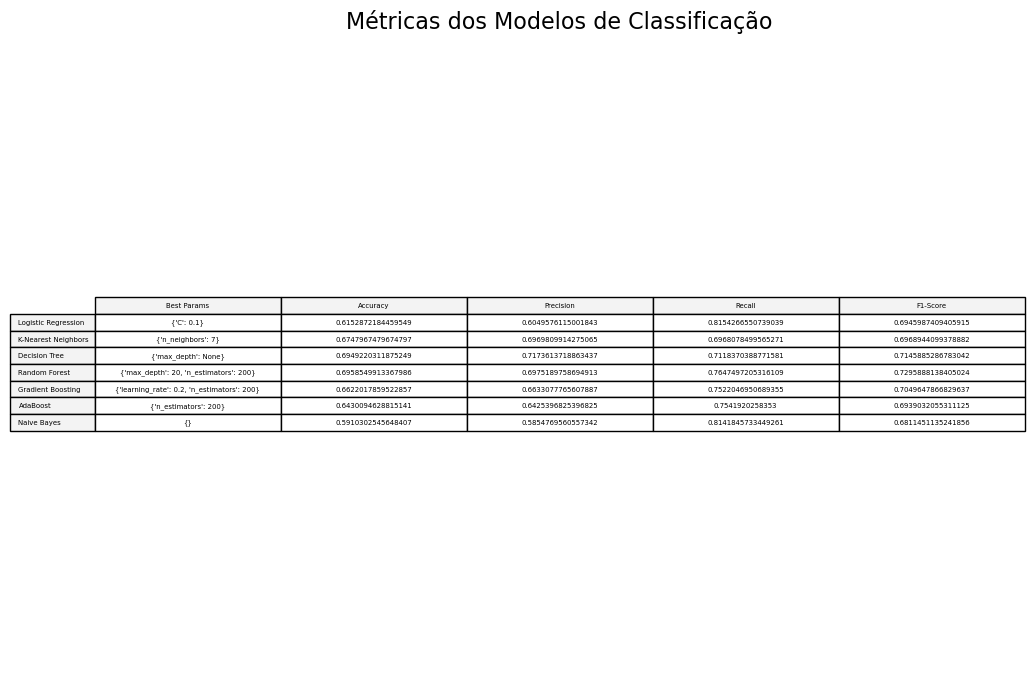

In [318]:
results_to_df(results_keep,"keep")

 
  Resultados dos Modelos com Otimização de Hiperparâmetros:
                                                     Best Params  Accuracy  \
Logistic Regression                                   {'C': 0.1}  0.617020   
K-Nearest Neighbors                           {'n_neighbors': 7}  0.675996   
Decision Tree                                {'max_depth': None}  0.695788   
Random Forest             {'max_depth': 20, 'n_estimators': 100}  0.695522   
Gradient Boosting    {'learning_rate': 0.2, 'n_estimators': 200}  0.662602   
AdaBoost                                   {'n_estimators': 200}  0.642676   
Naive Bayes                                                   {}  0.591497   

                     Precision    Recall  F1-Score  
Logistic Regression   0.605824  0.819153  0.696520  
K-Nearest Neighbors   0.697461  0.699540  0.698499  
Decision Tree         0.717929  0.713203  0.715559  
Random Forest         0.696059  0.767731  0.730140  
Gradient Boosting     0.665119  0.747485  0.7039

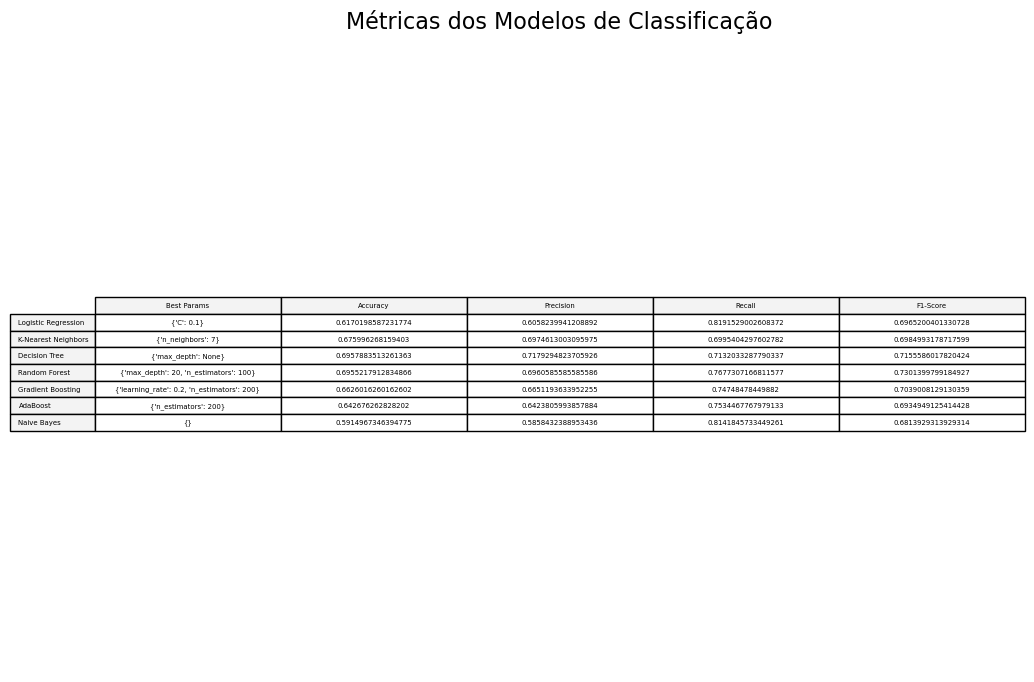

In [319]:
results_to_df(results_all,"all")

## Análise Comparativa dos Modelos de Classificação
### Resumo das Melhores F1-Scores em Cada Tabela
#### Dataset Keep
**Melhor modelo:** `Random Forest`
- **F1-Score:** 0.7295888138405024
- Accuracy: 0.6958549913367986
- Precision: 0.6975189758694913
- Recall: 0.7647497205316109


#### Dataset All
**Melhor modelo:** `Random Forest`
- **F1-Score:** 0.7301399799184927
- Accuracy: 0.6955217912834866
- Precision: 0.6960585585585586
- Recall: 0.7677307166811577


### Comparação entre os dois DataFrames
| Métrica      | Keep | All | Melhor |
|--------------|------------------|----------------|--------|
| **F1-Score** | 0.72958          | **0.73013**    | All |
| Accuracy     | 0.69585          | **0.69552**    | All |
| Precision    | **0.69758**      | 0.69691        | Keep |
| Recall       | 0.69751          | **0.76773**    | All |
Apesar das diferenças serem mínimas, o conjunto **“All”** apresenta ligeira vantagem em **F1-Score**, **Accuracy** e **Recall**.


### Resumo
- **Melhor modelo em ambos os datasets:** `Random Forest`.
- **Melhor dos dois DataFrames:** `All`, por apresentar:
  - **Maior F1-Score geral.**
  - Melhor desempenho em Accuracy e Recall.
  - Apenas uma ligeira desvantagem em Precision.

**Conclusão:** Utilizar o modelo **Random Forest treinado com o dataset "All"**, pela melhor performance global.

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='otm'></a>
    <h2 style="color: #003366; margin: 0;">3.2. Otimização do Modelo</h2>
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='hiper'></a>
    <h3 style="color: #003366; margin: 0;">3.2.1. Hiperparâmetros</h3>
</div>

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='rand'></a>
    <h3 style="color: #003366; margin: 0;">3.2.1.1. RandomSearch </h3>
</div>

In [529]:
#Criar uma cópia do all_data com o nome df
df=all_data.copy()

In [531]:
#Definir as variáveis independentes como X_data e a variável alvo como y_data. 
X_data = df.drop(['Sold'], axis = 1)
y_data = df['Sold']

In [533]:
#Criar uma instance do RandomForestClassifier com o nome dt 
dt = RandomForestClassifier(random_state=42)

**Parâmetros do Random Forest**

*Principais Parâmetros do RandomForestClassifier e RandomForestRegressor*

| Parâmetro               | Descrição |
|-------------------------|-----------|
| **`n_estimators`**      | Número de árvores na floresta (padrão = `100`). |
| **`criterion`**         | Medida para avaliar as divisões (`"gini"`, `"entropy"` para classificação; `"squared_error"`, `"absolute_error"` para regressão). |
| **`max_depth`**         | Profundidade máxima das árvores (`None` significa crescer até o final). |
| **`min_samples_split`** | Mínimo de amostras para dividir um nó (`2` por padrão). |
| **`min_samples_leaf`**  | Mínimo de amostras necessárias para formar uma folha (`1` por padrão). |
| **`max_features`**      | Número de recursos considerados em cada divisão (`"sqrt"`, `"log2"`, `None`). |
| **`bootstrap`**         | Se usa amostragem com reposição (`True` por padrão). |
| **`oob_score`**         | Se calcula erro fora da amostra (Out-Of-Bag, `False` por padrão). |
| **`random_state`**      | Define uma semente para reprodutibilidade. |




In [ ]:
#Definir um dicionário com o nome parameter_space_random e especificar as opções a serem consideradas durante a modelagem
parameter_space_random = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
}

In [ ]:
#Criar uma instance do RandomizedSearchCV com o nome random_search
random_search = RandomizedSearchCV(estimator = dt
                                   , param_distributions = parameter_space_random
                                   , scoring = 'f1'
                                   , cv=5
                                   , random_state = 42)

In [ ]:
#Ajustar a instance aos dados do x_data e y_data
random_search.fit(X_data, y_data)

print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='grid'></a>
    <h3 style="color: #003366; margin: 0;">3.2.1.2. GridSearch </h3>
</div>

In [ ]:
parameter_space_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
}

#Criar uma instance do GridSearchCV com o nome grid_search
grid_search = GridSearchCV(estimator = dt
                           , param_grid = parameter_space_grid
                           , scoring = 'f1'
                           , return_train_score = True
                           , cv = 5)

In [ ]:
#Ajustar a instance aos dados do x_data e y_data
grid_search.fit(X = X_data
                , y = y_data)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

In [ ]:
best_rf = grid_search.best_estimator_

In [ ]:
importances = best_rf.feature_importances_

In [ ]:
importances

In [ ]:
#Criar uma instance do RandomForestClassifier com o nome final_model_dt
final_model_dt = RandomForestClassifier(criterion = 'entropy'
                                        , max_depth = 5
                                        , min_samples_split = 2)

Treinando Random Forest com GridSearchCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

 Melhores hiperparâmetros encontrados: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Métricas do Random Forest:
Métrica    | Treino     | Teste     
-----------------------------------
Accuracy   | 0.6388    | 0.6363
Precision  | 0.6279    | 0.6266
Recall     | 0.8024    | 0.7974
F1-Score   | 0.7045    | 0.7018


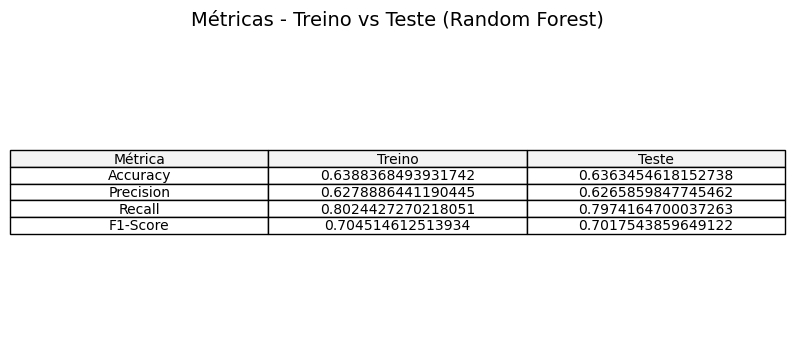

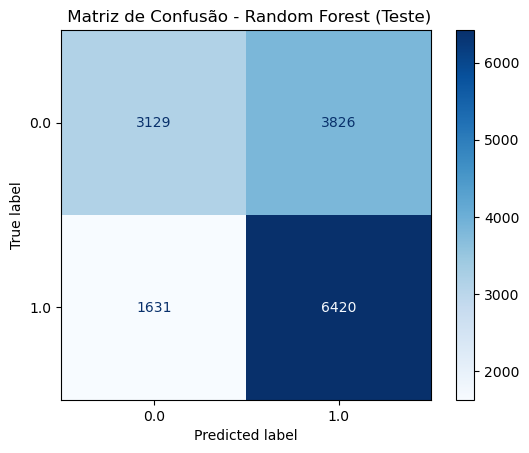

In [595]:
#Testar o modelo com ajuste de hiperparâmetros utilizado o GridSearchCV
X_train, X_test, y_train, y_test  = train_test_split(X_all_data, y_all_data, 
                                                  train_size = 0.9, 
                                                  random_state = 99, 
                                                  stratify = y_all_data)

param_grid = {'n_estimators': [100, 200],
    'max_depth': [2,3,4,5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

# Treinando com GridSearchCV
print("Treinando Random Forest com GridSearchCV...")
grid_search = GridSearchCV(dt, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print(f"\n Melhores hiperparâmetros encontrados: {grid_search.best_params_}")

# Fazendo predições no treino e teste
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Métricas no treino
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Métricas no teste
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Exibindo métricas no console
print("\n Métricas do Random Forest:")
print(f"{'Métrica':<10} | {'Treino':<10} | {'Teste':<10}")
print("-" * 35)
print(f"Accuracy   | {train_accuracy:.4f}    | {test_accuracy:.4f}")
print(f"Precision  | {train_precision:.4f}    | {test_precision:.4f}")
print(f"Recall     | {train_recall:.4f}    | {test_recall:.4f}")
print(f"F1-Score   | {train_f1:.4f}    | {test_f1:.4f}")

# Salvando as métricas em uma imagem
metrics_df = pd.DataFrame({
    "Métrica": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Treino": [train_accuracy, train_precision, train_recall, train_f1],
    "Teste": [test_accuracy, test_precision, test_recall, test_f1]
})

plt.figure(figsize=(10, 4))
plt.axis('off')
plt.table(cellText=metrics_df.values,
          colLabels=metrics_df.columns,
          loc='center',
          cellLoc='center',
          colColours=['#f3f3f3'] * 3)
plt.title("Métricas - Treino vs Teste (Random Forest)", fontsize=14, pad=10)
plt.savefig("metricas_treino_teste_rf.png", bbox_inches='tight', dpi=300)
plt.show()

# Matriz de confusão (teste)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(" Matriz de Confusão - Random Forest (Teste)")
plt.savefig("matriz_confusao_rf.png", dpi=300)
plt.show()

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='threshold'></a>
    <h3 style="color: #003366; margin: 0;">3.2.1.3. Alterar o threshold </h3>
</div>

In [597]:
df = all_data.copy()

X_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

In [598]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  train_size = 0.9, 
                                                  random_state = 99, 
                                                  stratify = y_data)

In [599]:
final_model = final_model_dt.fit(X_train, y_train)

In [600]:
#Calcular as probabilidades associadas a cada observação em X_val de pertencer à classe 0 ou 1.
predict_proba = final_model.predict_proba(X_val)

In [601]:
predict_proba

array([[0.61413496, 0.38586504],
       [0.36337523, 0.63662477],
       [0.33615885, 0.66384115],
       ...,
       [0.34207167, 0.65792833],
       [0.36085424, 0.63914576],
       [0.34512321, 0.65487679]])

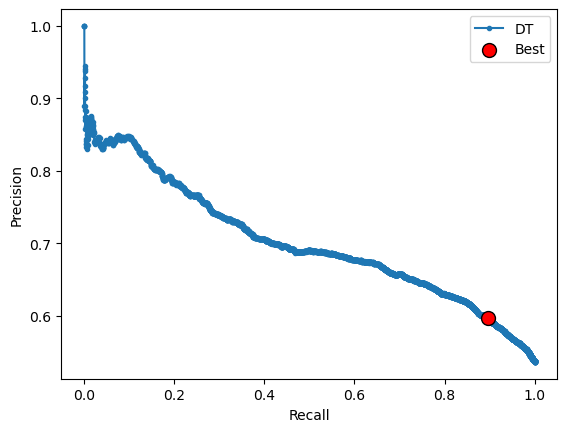

Best Threshold=0.391851, F-Score=0.717


In [602]:
# Calcula a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_val, predict_proba[:, 1])

# Calcula o F1-score para cada threshold
fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = 0  # Evita NaN caso precision + recall seja zero

# Encontra o índice do melhor F1-score
ix = np.argmax(fscore)
best_recall, best_precision = recall[ix], precision[ix]

# Plot da curva Precision-Recall
plt.plot(recall, precision, marker='.', label='DT', zorder=1)
# Adiciona o ponto do melhor threshold na frente
plt.scatter(best_recall, best_precision, marker='o', color='red', edgecolors='black', s=100, label='Best', zorder=2)

# Configuração dos eixos e legenda
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f'Best Threshold={thresholds[ix]:.6f}, F-Score={fscore[ix]:.3f}')

**Conclusões:**

Alterando o threshold para 0.391851, é possível melhorar o f1-score no nosso modelo final.

In [611]:
train = all_data.copy()

X_train = all_data.drop(['Sold'], axis = 1)
y_train = all_data['Sold']

In [613]:
final_model = final_model_dt.fit(X_train, y_train)

In [614]:
final_model.predict(X_val)

array([0., 1., 1., ..., 1., 1., 1.])

In [615]:
predict_proba_test = final_model.predict_proba(X_val)


In [616]:
predict_proba_test

array([[0.59923549, 0.40076451],
       [0.36222299, 0.63777701],
       [0.33716799, 0.66283201],
       ...,
       [0.35607521, 0.64392479],
       [0.35979047, 0.64020953],
       [0.34787312, 0.65212688]])

In [617]:
test_pred = []

for value in predict_proba_test[:,1]:
    if (value>=0.391851):
        test_pred.append(1)
    else:
        test_pred.append(0)

In [623]:
f1_score(y_val, test_pred)

0.7146534857378231

<div class="alert alert-block" style="background-color:#AEC6CF; border: 1px solid #003366">
<a id='deploy'>
<font color = '#003366'> 
    
# 4. Deploy</font>
</a>
    
</div>

In [626]:
train = all_data.copy()

X_data = train.drop(['Sold'], axis = 1)
y_data = train['Sold']

In [628]:
train.columns

Index(['Oldpvp', 'Selling_Square_Ft', 'Perc_Expiring_Sku', 'Discount', 'Brand',
       'District_Beja', 'District_Braga', 'District_Bragança',
       'District_Castelo Branco', 'District_Coimbra', 'District_Faro',
       'District_Guarda', 'District_Leiria', 'District_Lisboa',
       'District_Portalegre', 'District_Porto', 'District_Santarém',
       'District_Setúbal', 'District_Viana do Castelo', 'District_Vila Real',
       'District_Viseu', 'District_Évora', 'Type_Medium', 'Type_Small',
       'Sold'],
      dtype='object')

In [630]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  train_size = 0.9, 
                                                  random_state = 99, 
                                                  stratify = y_data)

In [632]:
final_model = final_model_dt.fit(X_train, y_train)

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='prev'></a>
    <h2 style="color: #003366; margin: 0;">4.1. Obter as previsões nos dados de teste a partir do modelo final</h2>
</div>

In [634]:
final_model.predict(X_val)

array([0., 1., 1., ..., 1., 1., 1.])

In [635]:
predict_proba_test = final_model.predict_proba(X_val)
predict_proba_test

array([[0.60696327, 0.39303673],
       [0.36404466, 0.63595534],
       [0.32683127, 0.67316873],
       ...,
       [0.35006056, 0.64993944],
       [0.365191  , 0.634809  ],
       [0.34352844, 0.65647156]])

In [636]:
final_pred = []

for value in predict_proba_test[:,1]:
    if (value>=0.391851):
        final_pred.append(1)
    else:
        final_pred.append(0)

final_pred

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [641]:
list(set(final_pred))


[0, 1]

<div style="background-color: '#006400'; padding: 15px; border: 1px solid #003366";">
    <a id='dataframe'></a>
    <h2 style="color: #003366; margin: 0;">4.2. Criação do DataFrame com o índice de cada linha e a respectiva previsão</h2>
</div>

In [644]:
answer = pd.DataFrame()
answer['Index'] = X_val.index
answer['Sold'] = final_pred
answer.head(20)

,Index,Sold
0,64456,1
1,49715,1
2,49229,1
3,79045,0
4,127369,1
5,3678,1
6,111291,1
7,147022,1
8,136715,1
9,124000,1


In [646]:
answer['Sold'].value_counts()

Sold
1    12115
0     1390
Name: count, dtype: int64

In [648]:
answer.to_csv('answer.csv', index = False)

In [650]:
best_rf.estimators_[0]

DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                       random_state=1608637542)

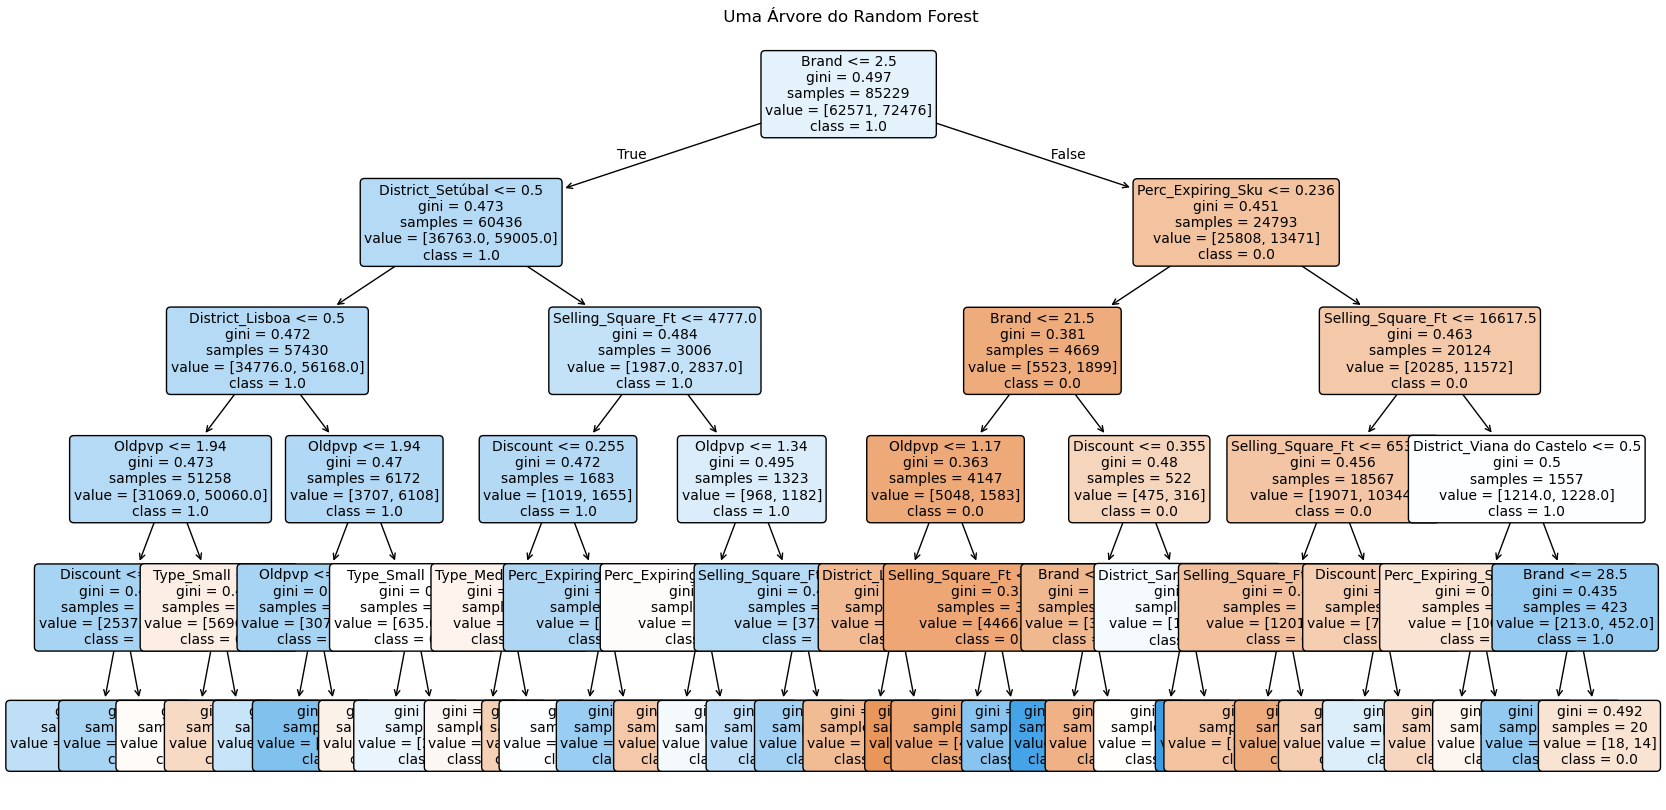

In [652]:

plt.figure(figsize=(20,10))
plot_tree(best_rf.estimators_[0],
          feature_names=X_data.columns,
          class_names=[str(cls) for cls in best_rf.classes_],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(" Uma Árvore do Random Forest")
plt.savefig("arvore_individual_rf.png", dpi=300)
plt.show()
